In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import cmath
from math import pi
import scipy.optimize as opt;
# Qiskit modules
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, IBMQ
from qiskit import execute
import qiskit.tools.visualization
from qiskit import transpile
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.quantum_info import state_fidelity

In [11]:
# Plot results
def graphic(exc,out,cr,E1,E2,phase_step,iterations,init):
    x=[]
    y1=[]
    y2=[]
    p1=0
    p2=0
    c=0.0299792 #cm/ps
    J=2*pi*126*c
    w=-2*pi*100*c
    Gamma=math.sqrt(math.pow(w,2)+4*math.pow(J,2))
    Lambda1=(w+Gamma)/2
    Lambda2=(w-Gamma)/2
    job=[]
    for cycles in range(0,iterations):
        qc = QuantumCircuit(exc,out,cr)
        one_qubit_fret(qc,exc,out,cr,E1,E2,phase_step,cycles,init)
        backend=provider0.get_backend('ibmq_london')
        qc = transpile(qc, backend, optimization_level=3)
        #backend=Aer.get_backend('qasm_simulator')
        job_sim = execute(qc, backend, shots=2048)
        job.append(job_sim.job_id())
        result_sim = job_sim.result()
        result_counts = result_sim.get_counts(qc)
        if '0' in result_counts:
            p1+=result_counts['0']/2048
        else:
            p1=0
        if '1' in result_counts:
            p2+=result_counts['1']/2048
        else:
            p2=0
        x.append(phase_step*cycles)
        y1.append(p1)
        y2.append(p2)
        p1=0
        p2=0
    #Plot
    def func0(x):
        return(math.pow(abs(Lambda1*cmath.exp(-1j*Lambda1*i)/Gamma-Lambda2*cmath.exp(-1j*Lambda2*i)/Gamma),2) for i in x)
    def func1(x):
        return(math.pow(abs(J*(cmath.exp(1j*Lambda1*i)-cmath.exp(1j*Lambda2*i))/Gamma),2) for i in x)
    
    la = plt.scatter(x,y1,c='b',marker="^",label='Simulation - P(0)')
    lb = plt.scatter(x,y2,c='r',label='Simulation - P(1)')
    t=np.linspace(0,iterations*phase_step,num=1000)
    y_t_1=list(func0(t))
    plt.plot(t, y_t_1, 'b',label="Theory - P(0)")
    y_t_2=list(func1(t))
    plt.plot(t,y_t_2 , 'r--',label="Theory - P(1)")
    ll = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lx = plt.xlabel('Time (ps)')
    ly = plt.ylabel('Probability')
    xx = plt.xlim(0,cycles*phase_step)
    plt.show()
    return(job)
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=1000)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

In [12]:
def u(fret,exc):
    fret.ry(-2*2.545,exc[0])

# Temporal Evolution Diagonal Hamiltonian
def hamiltonian_evolution(fret,exc,out,phase_step,E1,E2):
    ## 0
    fret.barrier()
    fret.x(exc[0])
    fret.crz(-2*E1*phase_step,exc[0],out[0])
    fret.x(exc[0])
    ## 1
    fret.barrier()
    fret.crz(-2*E2*phase_step,exc[0],out[0])
    
def u_transconj(fret,exc):  #the transconjugate of the decomposition (U) - 
                                #reverse implemention order and conjugate every matrix
    fret.ry(2*2.545,exc[0])

def state_initialization(fret,exc,out,init): 
    fret.x(out[0])
    if (init):
        fret.x(exc[0])

In [13]:
def one_qubit_fret(fret,exc,out,cr,E1,E2,phase_step,cycles,init):
    state_initialization(fret,exc,out,init)
    fret.barrier()
    u(fret,exc)
    hamiltonian_evolution(fret,exc,out,phase_step*cycles,E1,E2)
    u_transconj(fret,exc)
    fret.barrier()
    fret.measure(exc,cr)

In [14]:
#IBMQ.save_account('297b8d0b1e9973cc1224c6269b1388c76e41e64855425effa5938bd4ee6ca139956e9ff474041917c0d488cd3207431eed249438f98aa3e443efc9e525662b1d',overwrite=True)
#IBMQ.stored_account()

/home/jakumin/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


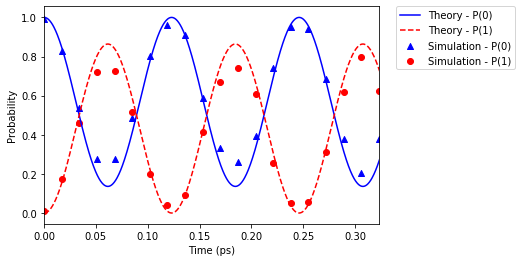

In [15]:
exc = QuantumRegister(1)
out = QuantumRegister(1) 
cr = ClassicalRegister(1) 
fret = QuantumCircuit(exc,out,cr)
c=0.0299792 #cm/ps
E1=82219*c
E2=80515.5*c
step_size=0.017   #step size 1 cm -> +- 33 ps
cycles=20

provider0 = IBMQ.load_account()
#provider0.backends()
#execute_locally(fret)
jobs=graphic(exc,out,cr,E1,E2,step_size,cycles,False)

/home/jakumin/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


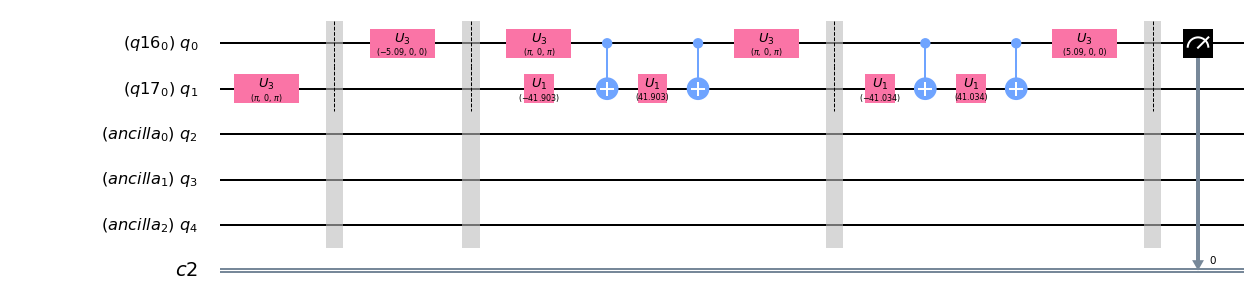

In [7]:
exc = QuantumRegister(1) # 1 qubit for exciton localizations
out = QuantumRegister(1) # 1 output qubit to apply diagonal hamiltonian
cr = ClassicalRegister(1) # 1 classical bit for state measurement
fret = QuantumCircuit(exc,out,cr)
c=0.0299792 #cm/ps
E1=82219*c
E2=80515.5*c
step_size=0.017
cycles=1


provider0 = IBMQ.load_account()
backend=provider0.get_backend('ibmq_london')
one_qubit_fret(fret,exc,out,cr,E1,E2,step_size,cycles,False)
qc = transpile(fret, backend, optimization_level=3)
qc.draw(output='mpl')